# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Infrastructure-for-multiple-realizations" data-toc-modified-id="Infrastructure-for-multiple-realizations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Infrastructure for multiple realizations</a></div><div class="lev1 toc-item"><a href="#Optimization" data-toc-modified-id="Optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimization</a></div><div class="lev1 toc-item"><a href="#Visualizing-fitted-kernel" data-toc-modified-id="Visualizing-fitted-kernel-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualizing fitted kernel</a></div><div class="lev2 toc-item"><a href="#Empirical-variogram" data-toc-modified-id="Empirical-variogram-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Empirical variogram</a></div><div class="lev2 toc-item"><a href="#Variogram-plots" data-toc-modified-id="Variogram-plots-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Variogram plots</a></div><div class="lev1 toc-item"><a href="#Simulations-from-prior" data-toc-modified-id="Simulations-from-prior-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulations from prior</a></div><div class="lev1 toc-item"><a href="#Understanding-the-periodic-kernel" data-toc-modified-id="Understanding-the-periodic-kernel-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Understanding the periodic kernel</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Fitting an entire year's data, even for just one station's data, is quite time consuming. We're not really interested in long-term correlations (like seasonal components), so it makes sense to divide the data up into smaller chunks (of a few weeks of data). Some information is lost, but I don't think any bias is introduced. If this means we can fit multiple stations' temperature time series, then this is a net win.

In [2]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, update_mll!, evaluate, metric
import GaussianProcesses: cov
import GaussianProcesses: optimize!, get_optim_target
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
using Optim
;

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/TimeSeries.ji for module TimeSeries.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/CategoricalArrays.ji for module CategoricalArrays.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/DataFrames.ji for module DataFrames.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/PositiveFactorizations.ji for module PositiveFactorizations.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Optim.ji for module Optim.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/PDMats.ji for module PDMats.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Distances.ji for module Distances.


In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/URIParser.ji for module URIParser.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Conda.ji for module Conda.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


In [4]:
include("src/preprocessing.jl")

test_data (generic function with 1 method)

In [5]:
usaf=725450
wban=14990
id=1
station_data=read_station(usaf,wban,id)
add_ts_hours!(station_data)
station_data[1:5,:]

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1,0.0
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1,1.0
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1,2.0
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1,3.0
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1,4.0


# Kernel Specification

In [6]:
k0 = Noise(-1.0)
k1 = FixedPeriodic(log(0.5), log(√(10.0)), log(24.0))
k2 = RQIso(log(2.0), log(√10.0), 3.0) # short term
k3 = SEIso(log(2.0), log(√10.0)) # short term SE
k4 = RQIso(log(1.0*24), log(√10.0), 3.0)
k5 = RQIso(log(10.0*24), log(√10.0), 3.0)
k6 = SE(log(100.0*24), log(√80.0))
_k=k0+k1+k2+k3+k4+k5
_k_nonoise=k1+k2+k3+k4+k5+k6
_logNoise=log(k0.σ2)/2.0
hyp=[-0.359207,0.36883,1.45171,2.0342,1.17682,2.88579,4.28659,1.49533,-0.16544,6.81425,1.3045,3.49925,7.34764,2.16028]
hyp_nonoise=[-1.49471,9.68156,0.28408,1.04675,-1.18377,-0.886588,-0.0974043,2.6959,2.41763,-3.61659,6.89384,1.18493,3.49553,7.7369,2.4648]
# set_params!(_k, hyp)
# set_params!(_k_nonoise, hyp_nonoise[3:end])
_logNoise=hyp_nonoise[1]
_meanfunc=MeanConst(0.0)
;

# Infrastructure for multiple realizations

In [7]:
type GPRealisations
    reals::Vector{GP}
    m::Mean
    k::Kernel
    logNoise::Float64
    dim::Int
    mLL::Float64
    dmLL::Vector{Float64}
end

In [8]:
function get_params(gpr::GPRealisations; noise::Bool=true, mean::Bool=true, kern::Bool=true)
    params = Float64[]
    if noise; push!(params, gpr.logNoise); end
    if mean;  append!(params, get_params(gpr.m)); end
    if kern; append!(params, get_params(gpr.k)); end
    return params
end
function propagate_params!(gpr::GPRealisations; noise::Bool=true, mean::Bool=true, kern::Bool=true)
    for gp in gpr.reals
        # harmonize parameters
        if kern
            gp.k = gpr.k
        end
        if mean
            gp.m = gpr.m
        end
        if noise
            gp.logNoise = gpr.logNoise
        end
    end
end
function set_params!(gpr::GPRealisations, hyp::Vector{Float64}; noise::Bool=true, mean::Bool=true, kern::Bool=true)
    # println("mean=$(mean)")
    if noise; gpr.logNoise = hyp[1]; end
    if mean; set_params!(gpr.m, hyp[1+noise:noise+num_params(gpr.m)]); end
    if kern; set_params!(gpr.k, hyp[end-num_params(gpr.k)+1:end]); end
    propagate_params!(gpr, noise=noise, mean=mean, kern=kern)
end

function update_mll!(gpr::GPRealisations)
    mLL = 0.0
    for gp in gpr.reals
        update_mll!(gp)
        mLL += gp.mLL
    end
    gpr.mLL = mLL
    return mLL
end
function update_mll_and_dmll!(gpr::GPRealisations, Kgrads::Dict{Int,Matrix}, ααinvcKIs::Dict{Int,Matrix}; kwargs...)
    mLL = 0.0
    for gp in gpr.reals
        update_mll_and_dmll!(gp, Kgrads[gp.nobsv], ααinvcKIs[gp.nobsv]; kwargs...)
        mLL += gp.mLL
    end
    gpr.dmLL = gpr.reals[1].dmLL
    for gp in gpr.reals[2:end]
        gpr.dmLL .+= gp.dmLL
    end
    gpr.mLL = mLL
    return gpr.dmLL
end
function update_mll_and_dmll!(gpr::GPRealisations; kwargs...)
    Kgrads = Dict{Int,Matrix}()
    ααinvcKIs = Dict{Int,Matrix}()
    for gp in gpr.reals
        if haskey(Kgrads, gp.nobsv)
            continue
        end
        Kgrads[gp.nobsv] = Array(Float64, gp.nobsv, gp.nobsv)
        ααinvcKIs[gp.nobsv] = Array(Float64, gp.nobsv, gp.nobsv)
    end
    return update_mll_and_dmll!(gpr, Kgrads, ααinvcKIs)
end
;

In [9]:
ts_vec = convert(Vector{Float64}, station_data[:ts_hours])
ts_arr = reshape(ts_vec, (1,length(ts_vec)));
temp_vec = convert(Vector{Float64}, station_data[:temp])
;

In [10]:
chunksize=300
istart=1
gprealisations=GP[]
while istart+chunksize < length(ts_arr)
    x = ts_arr[istart:istart+chunksize-1]
    y = temp_vec[istart:istart+chunksize-1]
    m = MeanConst(mean(y))
    gp = GP(x, y, m, _k_nonoise, _logNoise);
    push!(gprealisations, gp)
    istart+=chunksize
end

In [11]:
_gpr = GPRealisations(gprealisations, _meanfunc, _k_nonoise, _logNoise, 1, 0.0, Float64[]);
update_mll!(_gpr)
_gpr.mLL

-17205.51807266245

In [12]:
update_mll_and_dmll!(_gpr)
_gpr.dmLL

17-element Array{Float64,1}:
  7813.3      
     0.011439 
   184.816    
  -227.128    
  -519.116    
 -1227.95     
  -139.848    
  1060.78     
 -1455.53     
     3.42295  
    53.1789   
     0.399458 
    -8.99273  
     6.24337  
     0.0253697
    -0.915614 
   -30.4903   

In [13]:
function get_optim_target(gpr::GPRealisations; noise::Bool=true, mean::Bool=true, kern::Bool=true)
    Kgrads = Dict{Int,Matrix}()
    ααinvcKIs = Dict{Int,Matrix}()
    for gp in gpr.reals
        if haskey(Kgrads, gp.nobsv)
            continue
        end
        Kgrads[gp.nobsv] = Array(Float64, gp.nobsv, gp.nobsv)
        ααinvcKIs[gp.nobsv] = Array(Float64, gp.nobsv, gp.nobsv)
    end
    function mll(hyp::Vector{Float64})
        try
            set_params!(gpr, hyp; noise=noise, mean=mean, kern=kern)
            update_mll!(gpr)
            return -gpr.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(gpr, hyp; noise=noise, mean=mean, kern=kern)
            update_mll_and_dmll!(gpr, Kgrads, ααinvcKIs; noise=noise, mean=mean, kern=kern)
            grad[:] = -gpr.dmLL
            return -gpr.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    return func
end


get_optim_target (generic function with 2 methods)

In [14]:
@time update_mll_and_dmll!(_gpr, mean=false);

  2.500981 seconds (15.11 M allocations: 234.280 MB, 1.03% gc time)


In [15]:
_func = get_optim_target(_gpr, mean=false)

Optim.DifferentiableFunction(mll,dmll!,mll_and_dmll!)

In [16]:
import Calculus

In [17]:
_x=get_params(_gpr, mean=false)
numgrad = Calculus.gradient(_func.f, _x)

16-element Array{Float64,1}:
 -7813.3      
  -184.816    
   227.128    
   519.116    
  1227.95     
   139.848    
 -1060.78     
  1455.53     
    -3.42296  
   -53.1788   
    -0.399471 
     8.99278  
    -6.24354  
    -0.0252933
     0.915607 
    30.4903   

In [18]:
anlgrad=similar(numgrad) # analytical gradient
_func.g!(_x, anlgrad)

17205.51807266245

In [19]:
for (i,j) in zip(numgrad,anlgrad)
    @printf("%10.3f %10.3f\n", i, j)
    @assert isapprox(i,j, rtol=1e-4, atol=1e-3)
end

 -7813.297  -7813.297
  -184.816   -184.816
   227.128    227.128
   519.116    519.116
  1227.953   1227.953
   139.848    139.848
 -1060.785  -1060.785
  1455.534   1455.534
    -3.423     -3.423
   -53.179    -53.179
    -0.399     -0.399
     8.993      8.993
    -6.244     -6.243
    -0.025     -0.025
     0.916      0.916
    30.490     30.490


In [38]:
function optimize!(gpr::GPRealisations; noise::Bool=true, mean::Bool=true, kern::Bool=true,
                    method=ConjugateGradient(), kwargs...)
    func = get_optim_target(gpr, noise=noise, mean=mean, kern=kern)
    init = get_params(gpr;  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    set_params!(gpr, Optim.minimizer(results), noise=noise,mean=mean,kern=kern)
    update_mll!(gpr)
    return results
end

optimize! (generic function with 2 methods)

# Optimization

In [39]:
@time opt_out=optimize!(_gpr, mean=false, show_trace=true, x_tol=1e-5, f_tol=1e-5);

Iter     Function value   Gradient norm 
     0     1.245778e+04     2.577479e+01
     1     1.245769e+04     1.082656e+01
 14.138416 seconds (105.51 M allocations: 1.577 GB, 1.00% gc time)


In [40]:
opt_out

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.4622927394711194,-0.07778089653554916, ...]
 * Minimizer: [-1.4645910527380865,-0.07865840914652485, ...]
 * Minimum: 1.245769e+04
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 1.0e-05: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-05: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 6
 * Gradient Calls: 5

In [42]:
print(Optim.minimizer(opt_out))

[-1.46459,-0.0786584,1.03918,1.46075,1.06138,-1.23806,-1.23485,-1.05238,3.10521,1.29358,2.84732,3.67473,0.537729,3.00939,7.70676,-5.30466]

In [24]:
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.σ2)
@printf("l: %5.3f\n", √k1.ℓ2)
@printf("p: %5.0f hours\n", k1.p)
print("\nk₂: RQIso \n=================\n")
@printf("σ: %5.3f\n", √ k2.σ2)
@printf("l: %5.3f hours\n", √ k2.ℓ2)
@printf("α: %5.3f\n", k2.α)
print("\nk₃: SEIso \n=================\n")
@printf("σ: %5.3f\n", √k3.σ2)
@printf("l: %5.3f hours\n", √k3.ℓ2)
print("\nk₄: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k4.σ2)
@printf("l: %5.3f days\n", √k4.ℓ2 / 24)
@printf("α: %5.3f\n",  k4.α)
print("\nk₅: RQIso \n=================\n")
@printf("σ: %5.3f\n", √k5.σ2)
@printf("l: %5.3f days\n", √k5.ℓ2 / 24)
@printf("α: %5.3f\n",  k5.α)
print("\nk₆ SEIso \n=================\n")
@printf("σ: %5.3f\n", √k6.σ2)
@printf("l: %5.3f days\n", √k6.ℓ2 / 24)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(_gpr.logNoise))

k₁: Periodic 
σ: 2.825
l: 0.925
p:    24 hours

k₂: RQIso 
σ: 2.895
l: 4.295 hours
α: 0.290

k₃: SEIso 
σ: 0.350
l: 0.291 hours

k₄: RQIso 
σ: 3.645
l: 0.931 days
α: 17.241

k₅: RQIso 
σ: 1.712
l: 1.643 days
α: 20.275

k₆ SEIso 
σ: 0.005
l: 92.639 days

σy: 0.232


# Visualizing fitted kernel

## Empirical variogram

In [25]:
function variogram(times, values, bins)
    npairs = zeros(Int, length(bins))
    sqdiff_accum = zeros(Float64, length(bins))
    n = length(times)
    for (i, t1) in enumerate(times)
        ibin = 1
        for j in i:n
            Δt = times[j] - t1
            while Δt>bins[ibin]
                ibin += 1
            end
            npairs[ibin] += 1
            sqdiff_accum[ibin] += (values[j]-values[i])^2
        end
    end
    return sqdiff_accum ./ (npairs.*2)
end

_bins = collect(0:400*24)
station_variog = variogram(ts_vec, temp_vec.-mean(temp_vec), _bins)
;

## Variogram plots

In [26]:
# Assume all components are stationary
function cov(sumkern::SumKernel, r::Float64)
    ck = 0.0
    for k in sumkern.kerns
        metr = evaluate(metric(k), [r], [0.0])
        ck += cov(k, metr)
    end
    return ck
end
;

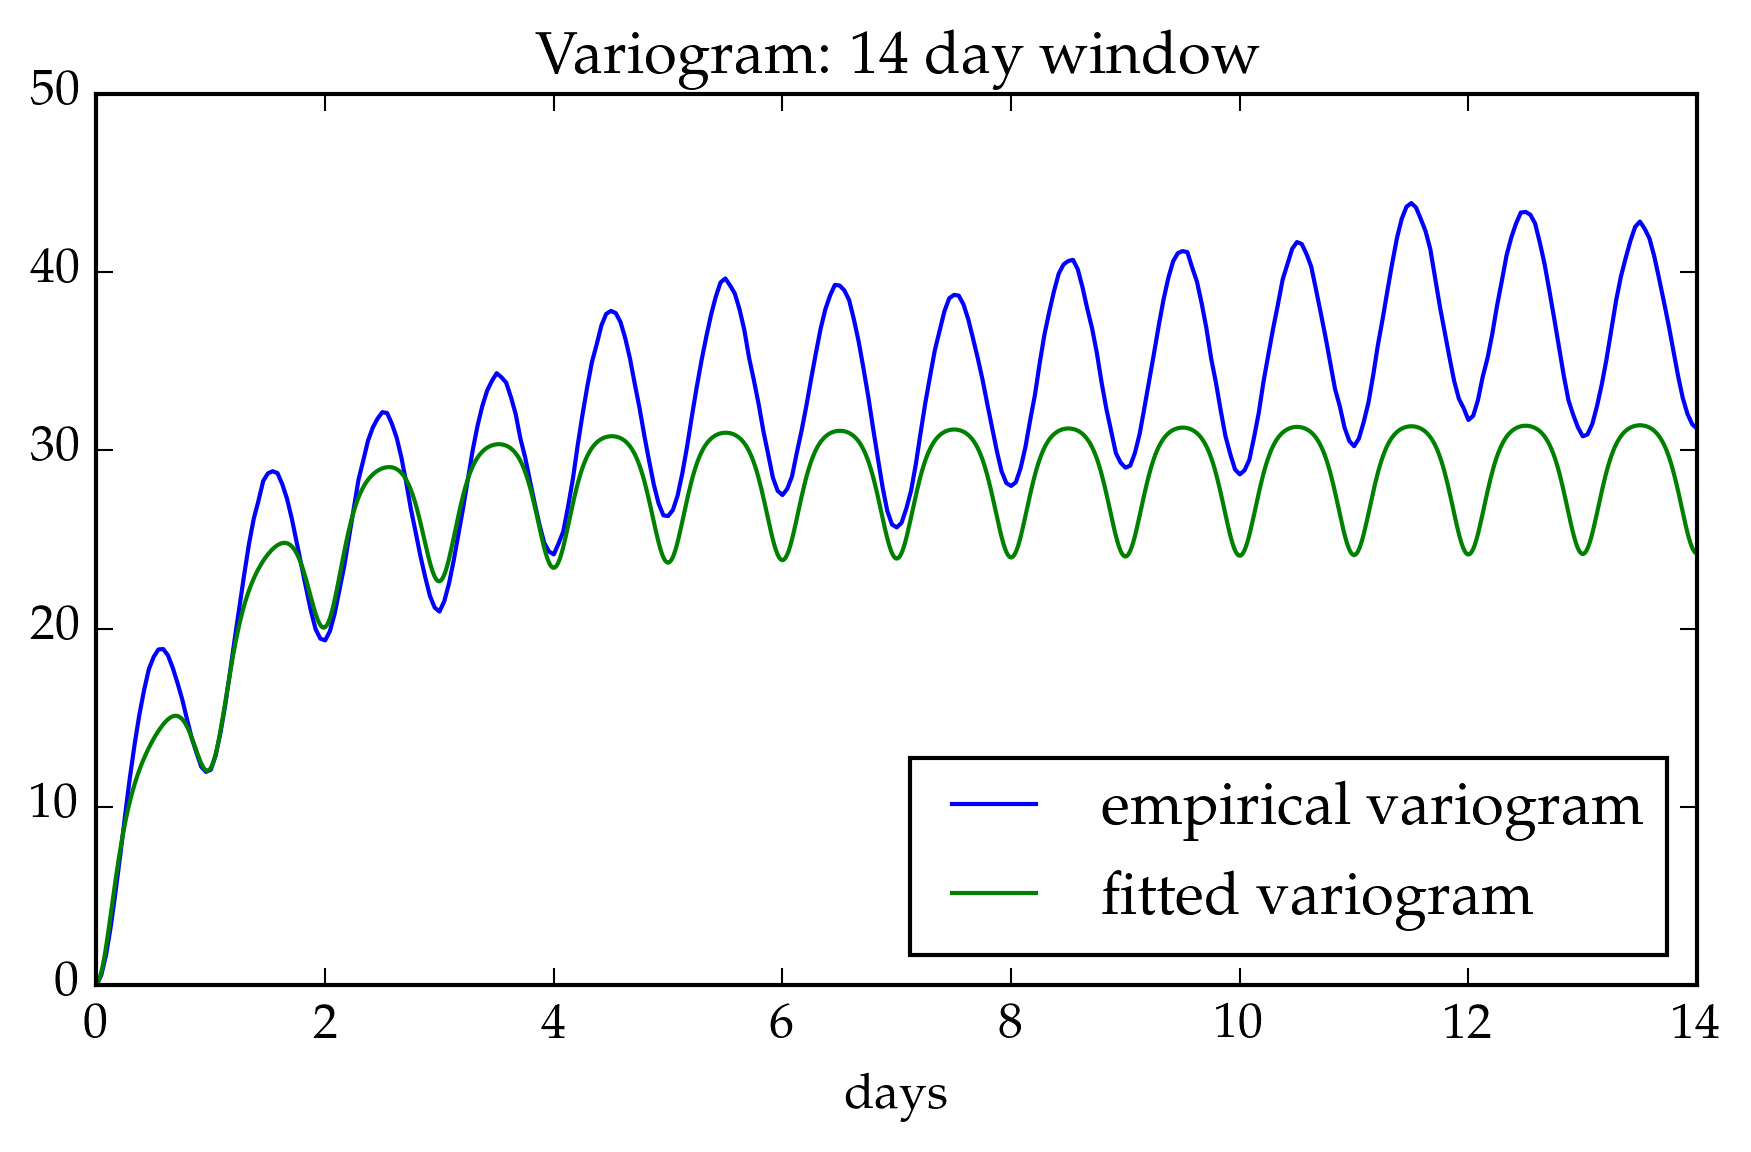

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [27]:
begin
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, label="empirical variogram")
    plt.ylim(0,50)
    plt.xlim(0,14)
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24.0, exp(2.0*_gpr.logNoise)+ck_r[1].-ck_r, label="fitted variogram")
    plt.legend(loc="lower right")
    plt.xlabel("days")
        plt.title("Variogram: 14 day window")
end
;

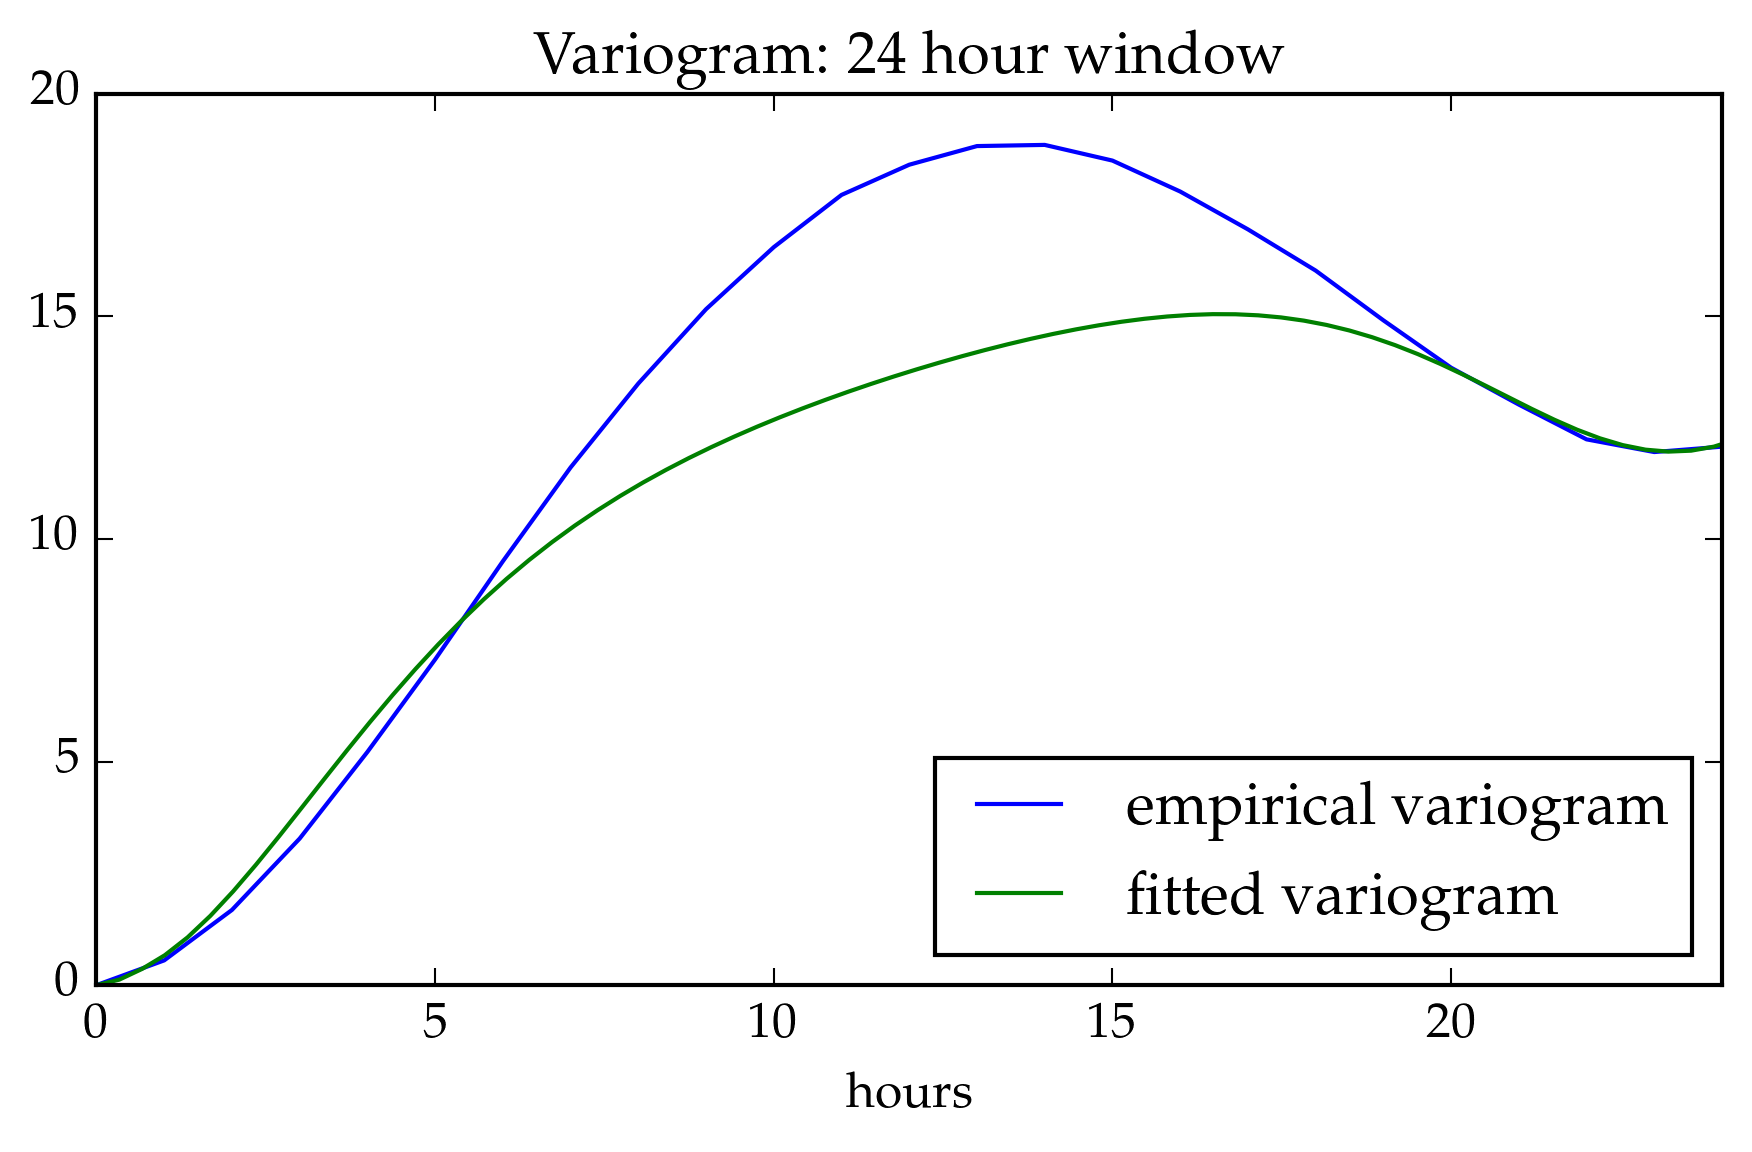

In [28]:
begin
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_hours, station_variog, label="empirical variogram")
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr, ck_r[1].-ck_r, label="fitted variogram")
    plt.legend(loc="lower right")
    plt.xlabel("hours")
    plt.ylim(0,20)
    plt.xlim(0,24)
    plt.title("Variogram: 24 hour window")
end
;

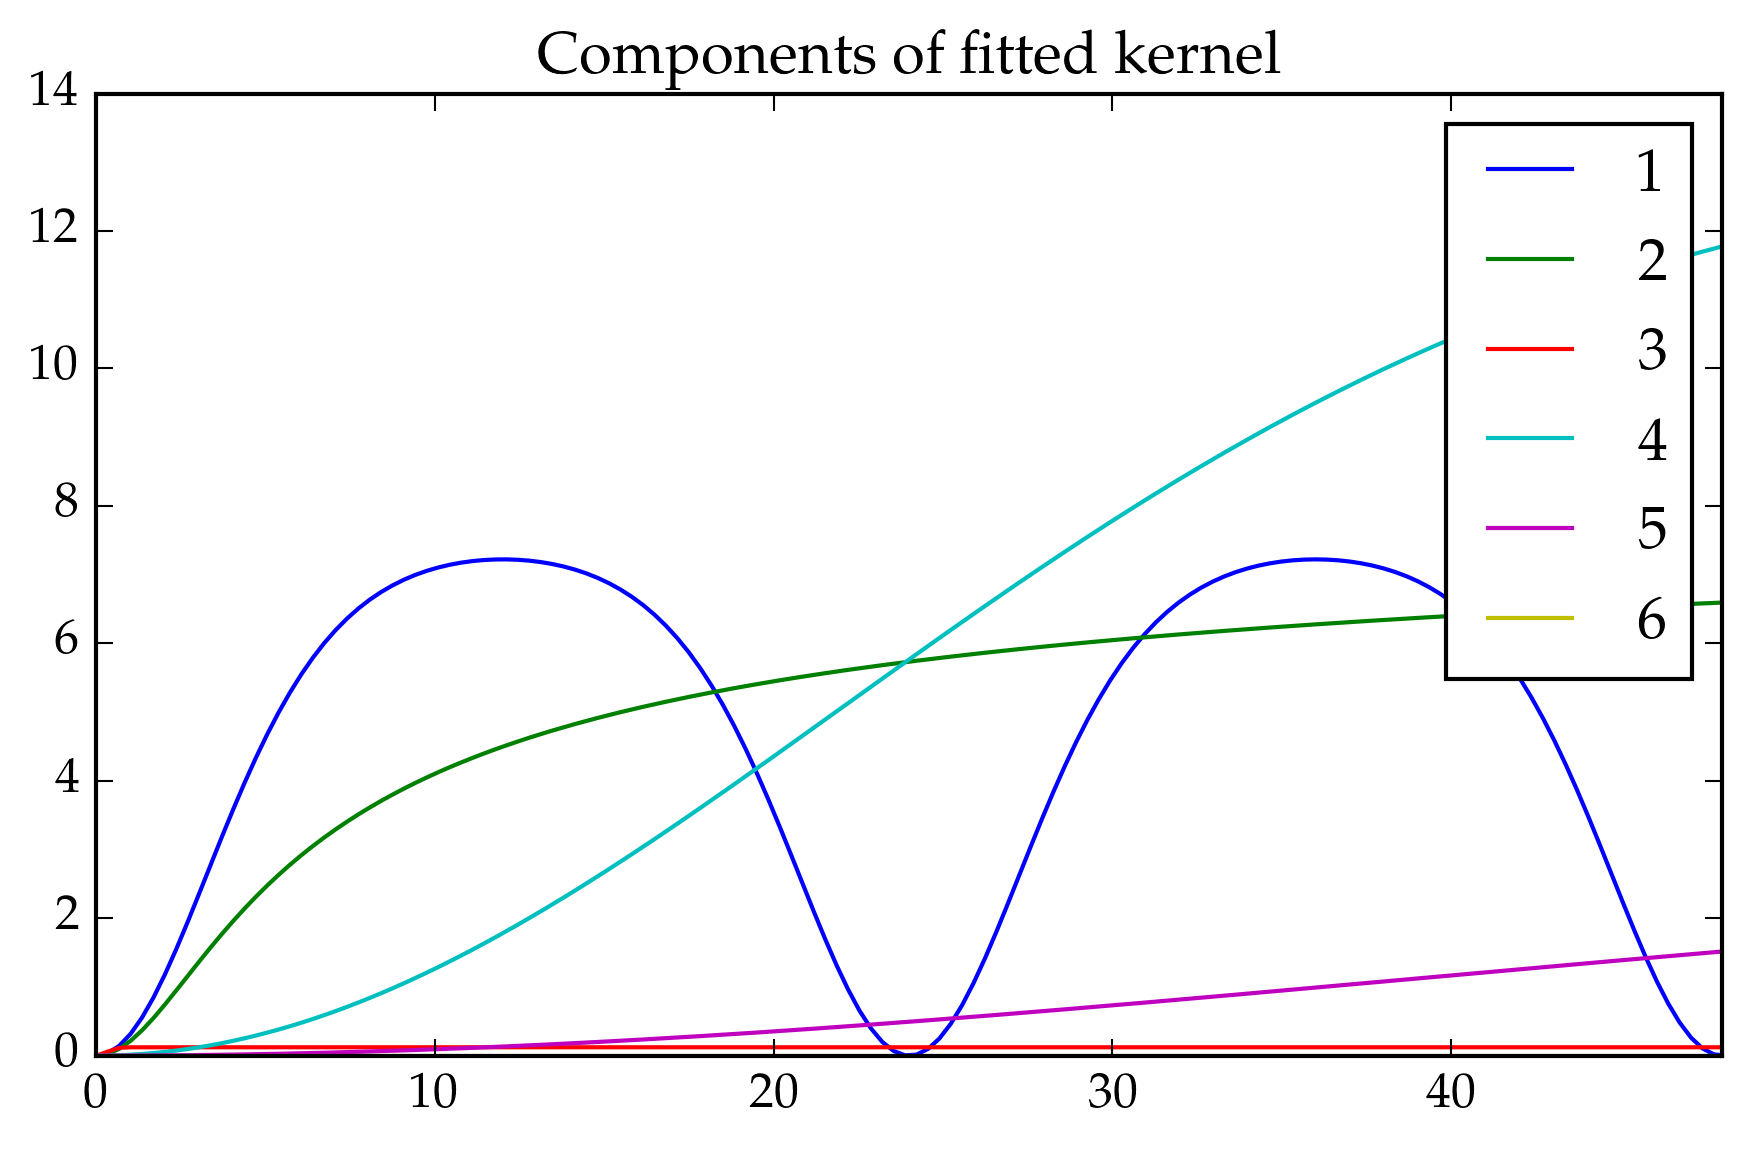

In [43]:
begin
    rr = linspace(0.0, 24*14, 1000)
    for (i,k) in enumerate(_k_nonoise.kerns)
        cki_r = [cov(k, evaluate(metric(k), [r], [0.0])) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, label=string(i));
    end
    plt.xlim(0,24*2)
    plt.legend(loc="upper right")
    plt.title("Components of fitted kernel")
end
;

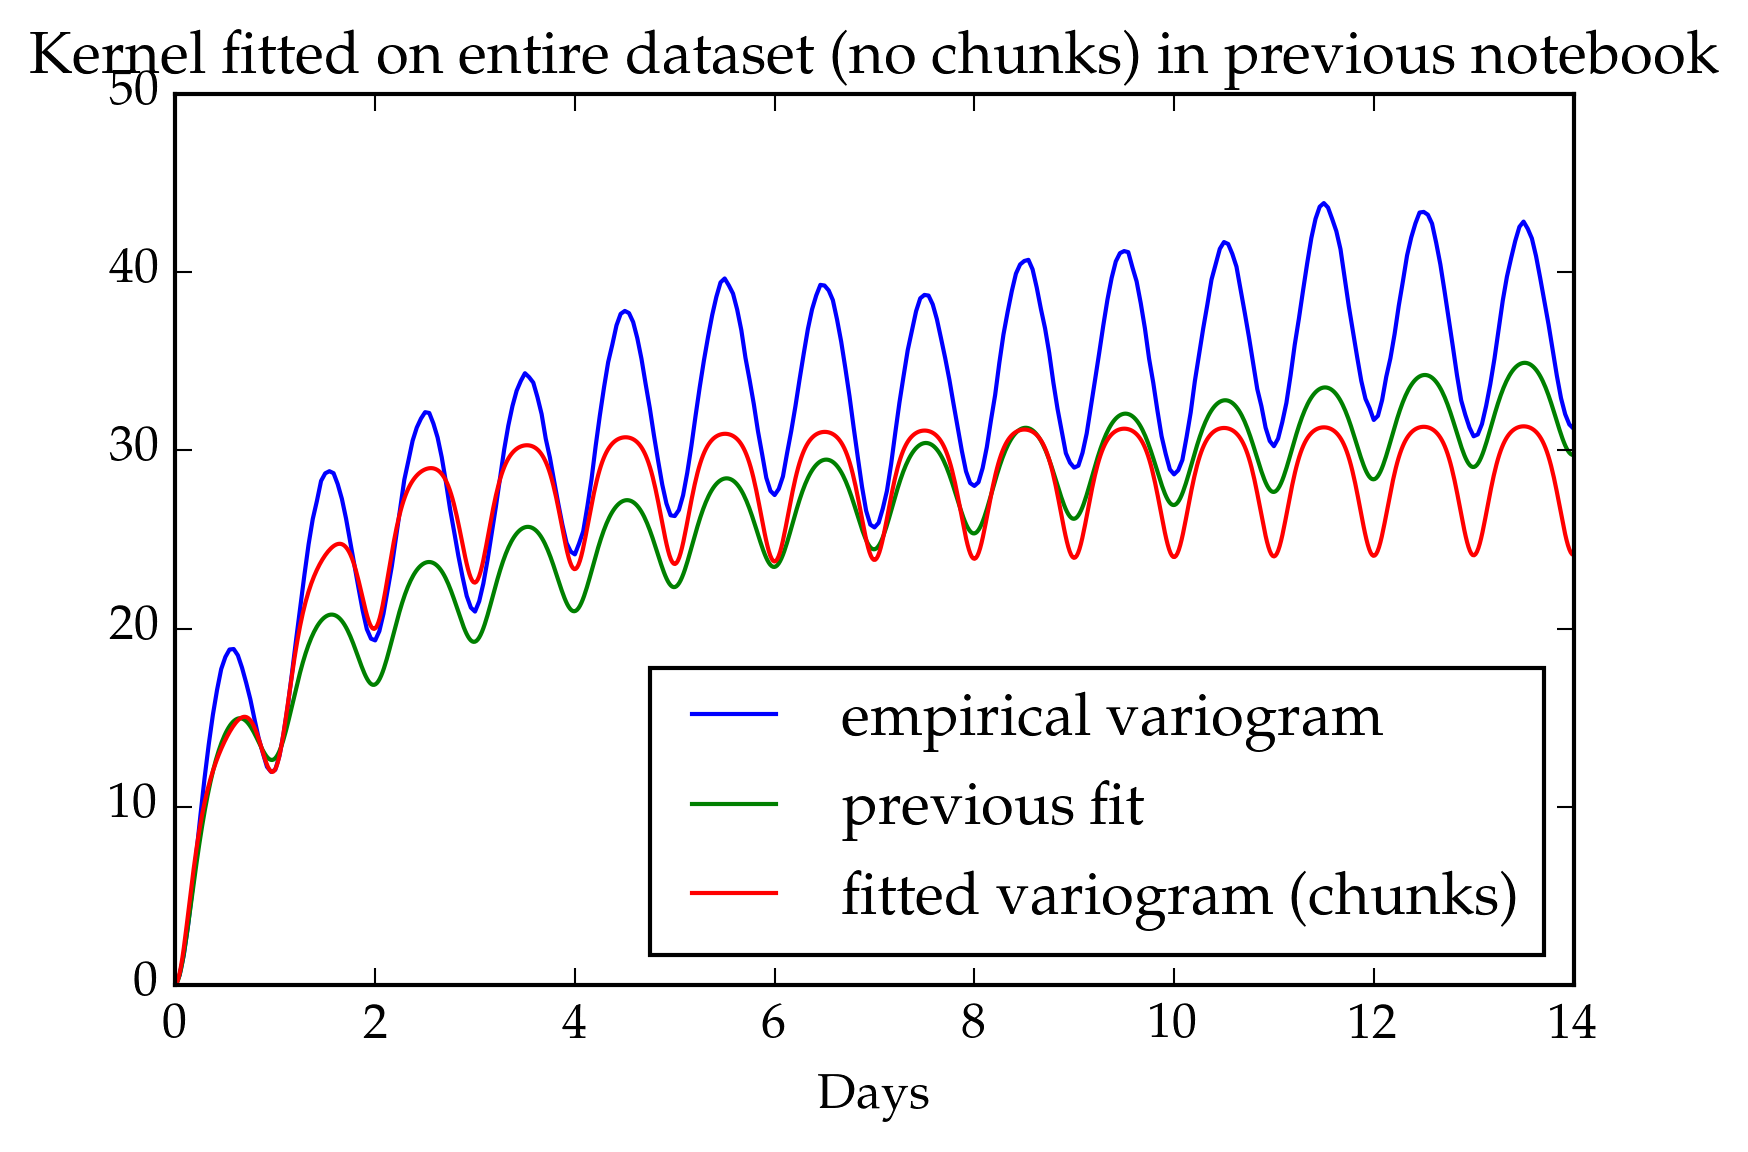

In [45]:
begin
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    plt.plot(bins_days, station_variog, label="empirical variogram")
    __k0 = Noise(0.0)
    __k1 = FixedPeriodic(log(0.5), log(√(10.0)), log(24.0))
    __k2 = RQIso(log(0.1*24), log(√10.0), 3.0) # short term
    __k3 = RQIso(log(3.0*24), log(√20.0), 3.0)
    __k4 = RQIso(log(10.0*24), log(√20.0), 3.0)
    __k5 = SE(log(200.0*24), log(√80.0))
    __k_nonoise=__k1+__k2+__k3+__k4+__k5
    set_params!(__k_nonoise, hyp_nonoise[3:end] )
    rr = linspace(0.0, 24*14, 1000)
    _ck_r = [cov(__k_nonoise, r) for r in rr]
    plt.plot(rr/24, _ck_r[1]-_ck_r, label="previous fit")
    
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr/24, ck_r[1].-ck_r, label="fitted variogram (chunks)")
    
    plt.xlim(0,14)
    plt.ylim(0,50)
    plt.xlabel("Days")
    plt.legend(loc="lower right")
    plt.title("Kernel fitted on entire dataset (no chunks) in previous notebook")
end
;

Looking at the variograms, the fit is pretty close, though I had hoped for an even closer match, given the flexibility of the kernel. In particular, the amplitude of the periodic component clearly looks too small. It's possible that the model is trading off fitting short-term correlations very well, at the expense of the diurnal and longer components.

# Simulations from prior

It's worth also simulating a few time series from the prior with the kernel hyperparameters as fitted above. Visually comparing this to the real data, we can check that they look similar, in terms of amplitude and timescales of temperature changes.

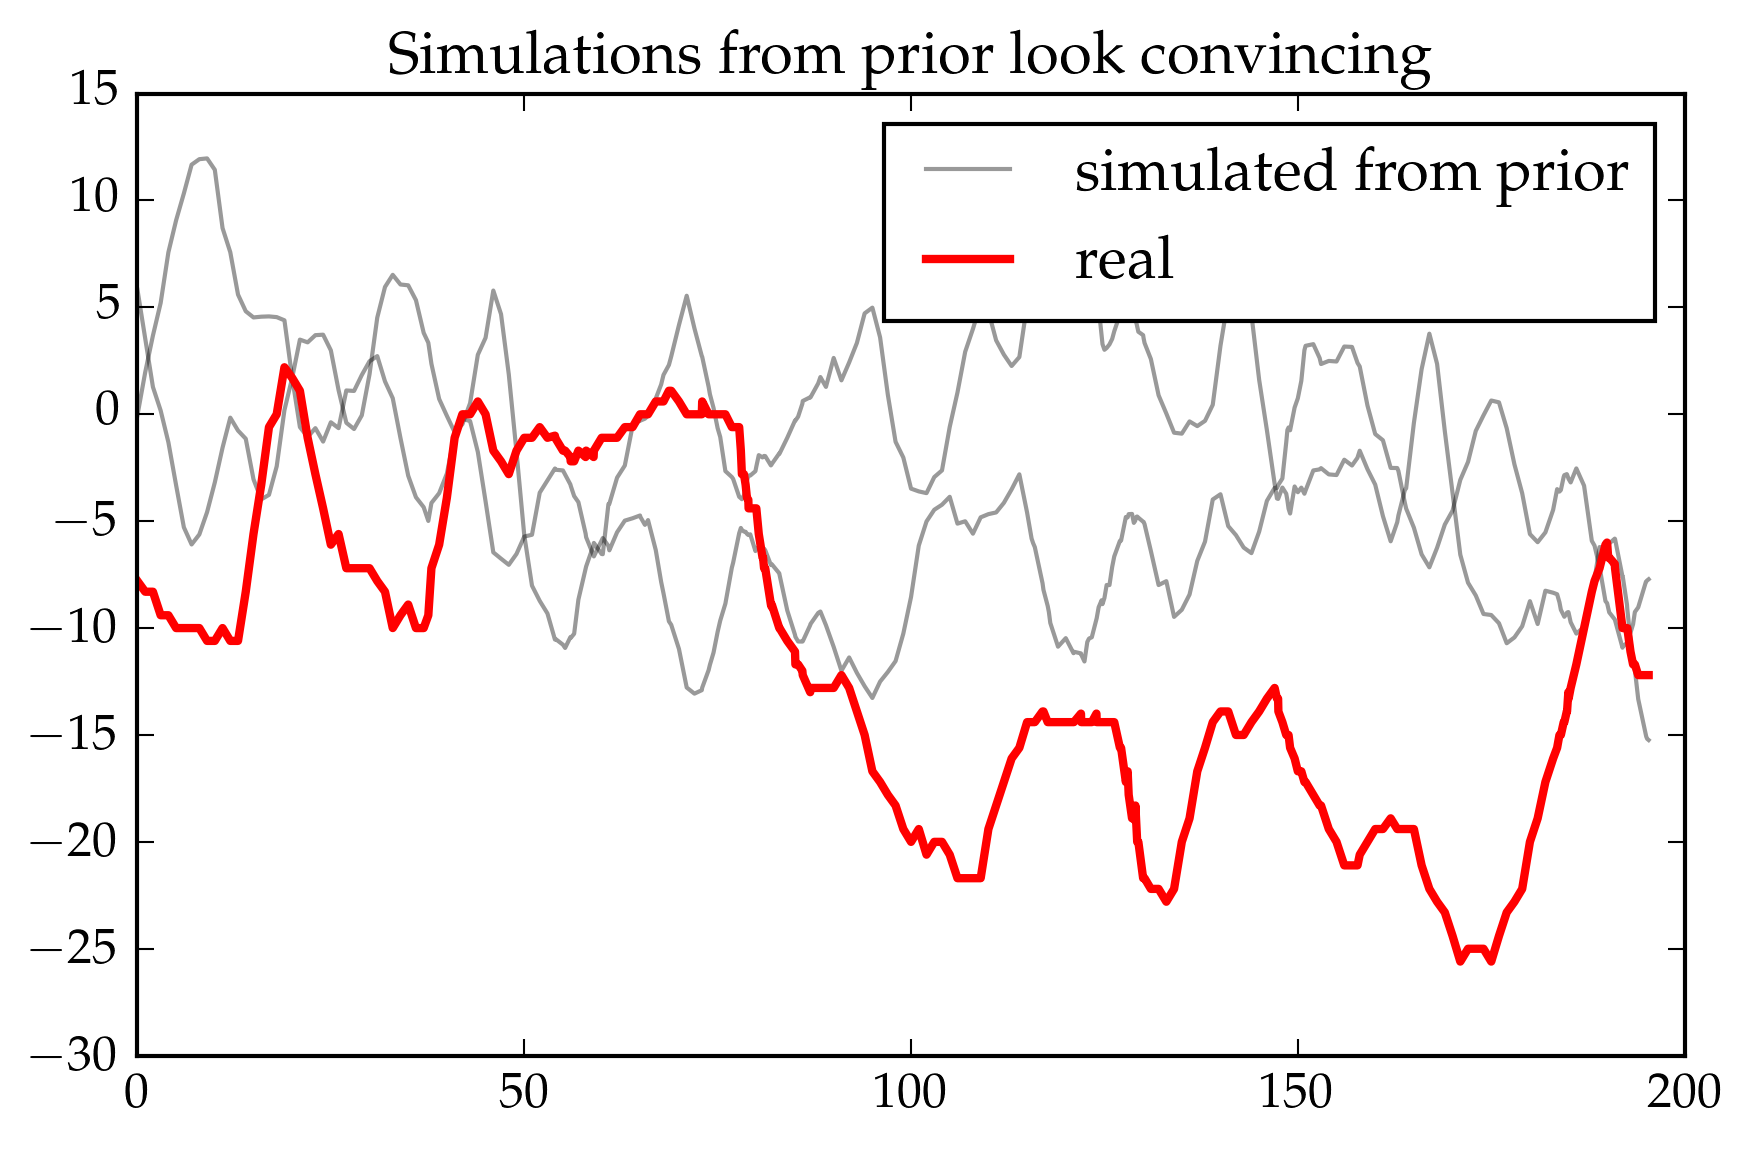

In [31]:
begin 
    gp_prior = GP(zeros(1,0), zeros(0), MeanConst(0.0), _k_nonoise, _gpr.logNoise)
    gp = _gpr.reals[1]
    x = gp.X
    plt.plot(vec(x), rand(gp_prior, x), color="black", alpha=0.4, label="simulated from prior")
    plt.plot(vec(x), rand(gp_prior, x), color="black", alpha=0.4)
    plt.plot(vec(x), gp.y, color="red", linewidth=2, label="real")
    plt.legend()
    plt.title("Simulations from prior look convincing")
end
;

# Understanding the periodic kernel

It looks to be like the periodic component's amplitude is too small in our fitted model. My intuition is that $\GP$s care more about fitting short-term correlations than long-term correlations (the opposite of a human fitting a variogram by eye). In the 24hr plot, it looks like the fitted variogram is overshooting its empirical counterpart slightly at $\Delta t= 2$ hours, and looking at the individual components of the fitted kernel, it's clear that this is driven by the period kernel. Therefore the fitted model might be choosing a reduced amplitude in order to reduce this discrepancy at low lags. What we want is a periodic kernel that is flatter at short lags. Let's explore our options.

In [32]:
# Reminder of the fitted periodic kernel
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.σ2)
@printf("l: %5.3f\n", √k1.ℓ2)
@printf("p: %5.0f hours\n", k1.p)

k₁: Periodic 
σ: 2.825
l: 0.925
p:    24 hours


The periodic kernel I'm using here has three parameters ($\sigma$, $\l$ and $p$) and is defined as:
$$k(t,t') = \sigma^2 \exp\del{ - \frac{2}{\l^2} \sin^2(\pi (t-t') / p)}$$
Let's visually explore what the $\l$ parameter does.

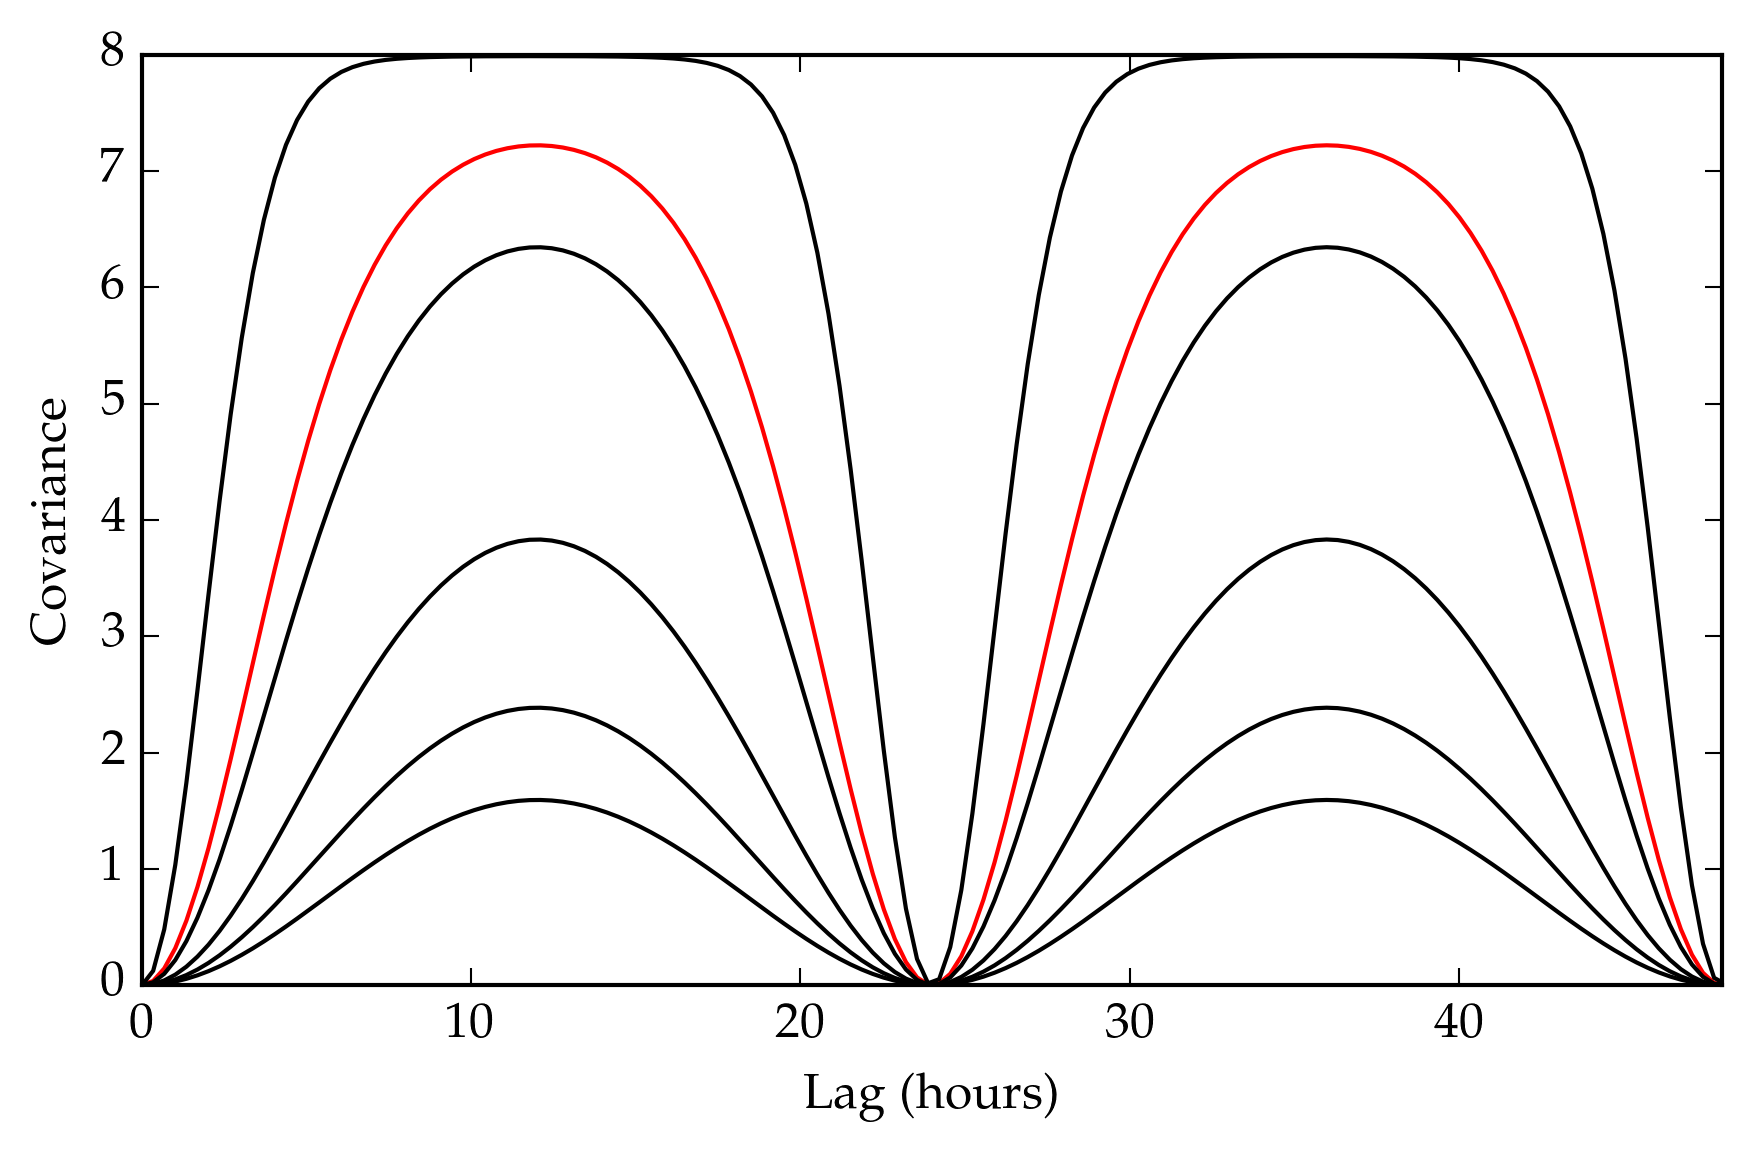

In [49]:
begin
    cki_r = [cov(k1, evaluate(metric(k1), [r], [0.0])) for r in rr]
    plt.plot(rr, cki_r[1]-cki_r, color="red")
    for 𝓁 in linspace(0.5,3.0,5)
        k = Periodic(log(𝓁), log(k1.σ2)/2.0, log(k1.p))
        cki_r = [cov(k, evaluate(metric(k), [r], [0.0])) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, color="black")
    end
end
plt.ylabel("Covariance")
plt.xlabel("Lag (hours)")
plt.xlim(0,24*2)
;

So, shorter $\l$ values correspond to a steeper rise in the variogram. But the effect is confusing because it also affects the amplitude of the kernel. Let's reparametrize the kernel and keep it constant.

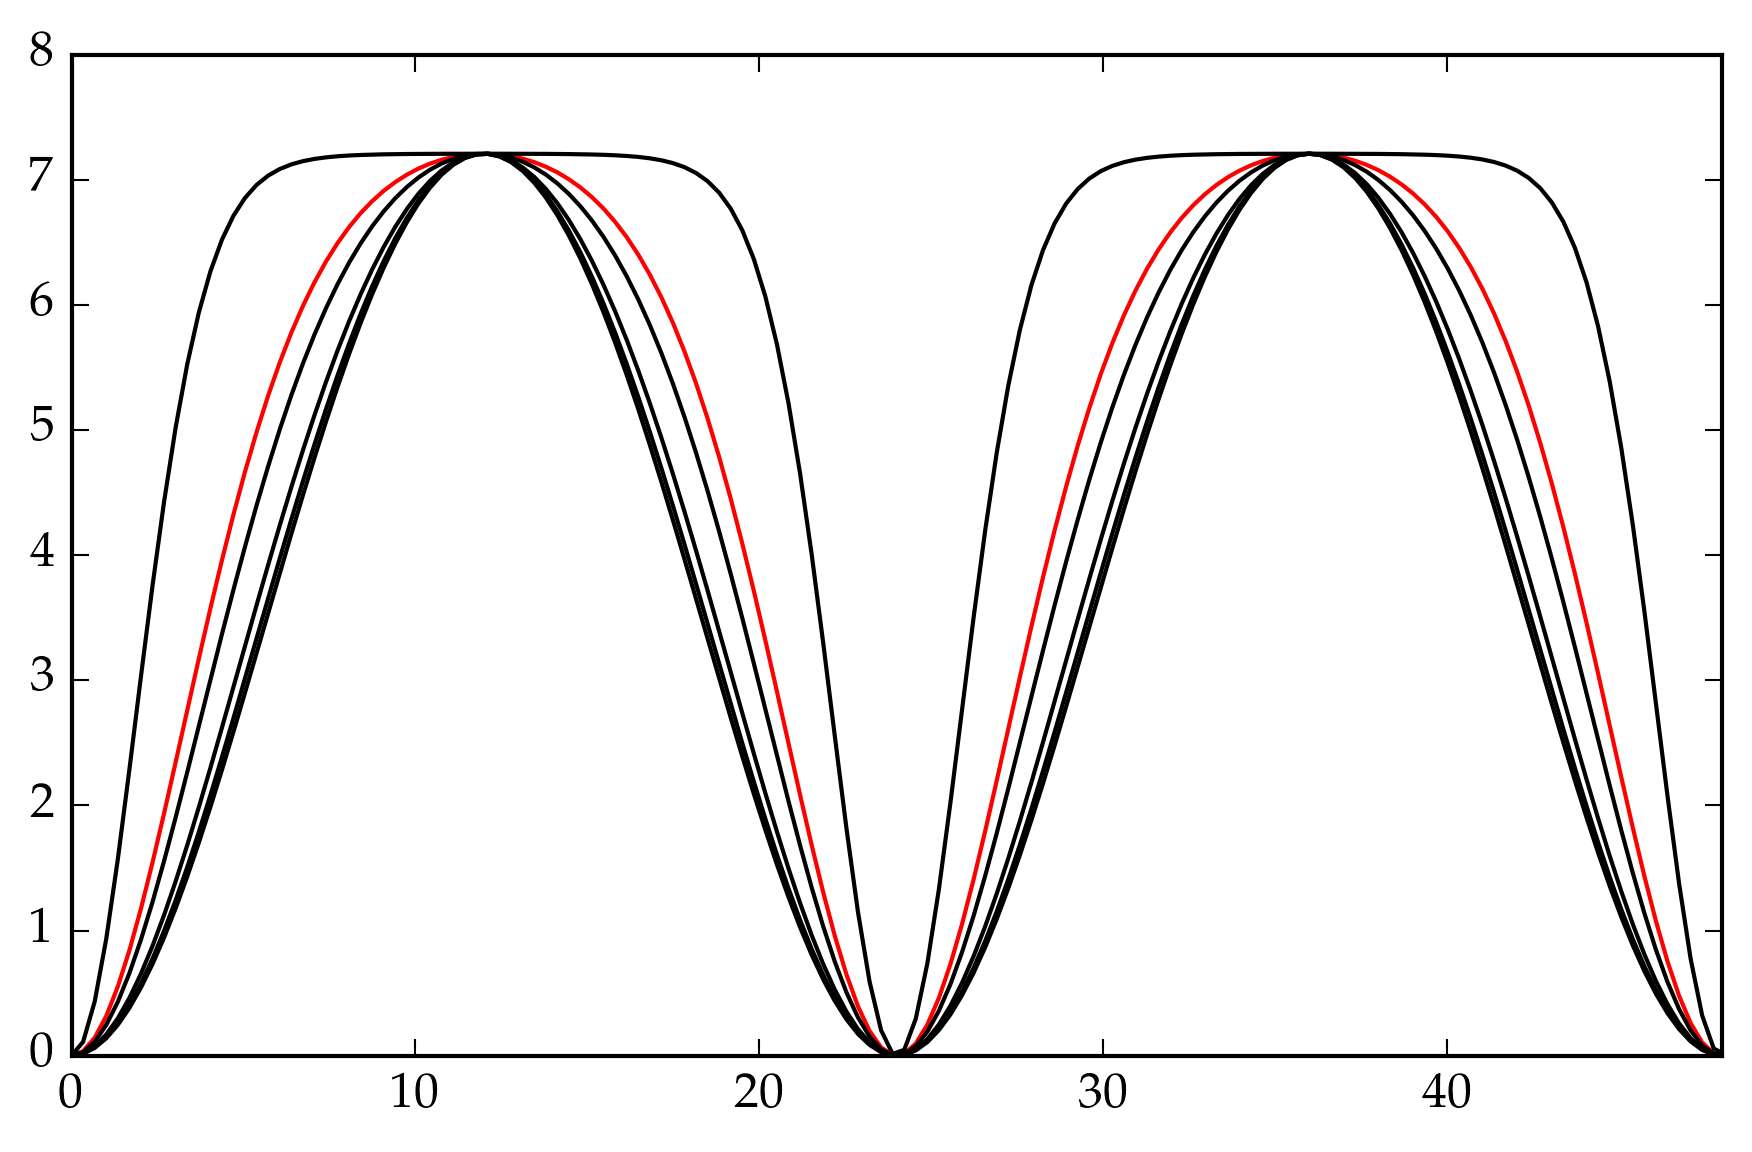

In [34]:
begin
    rr = linspace(0.0, 24*14, 1000)
    cki_r = [cov(k1, evaluate(metric(k1), [r], [0.0])) for r in rr]
    target_max = k1.σ2-cov(k1, evaluate(metric(k1), [12.0], [0.0]))
    plt.plot(rr, cki_r[1]-cki_r, color="red")
    for 𝓁 in linspace(0.5,3.0,5)
        k = Periodic(log(𝓁), 0.0, log(k1.p))
        max_ck = 1.0-cov(k, evaluate(metric(k), [12.0], [0.0]))
        k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, log(k1.p))
        cki_r = [cov(k_scaled, evaluate(metric(k_scaled), [r], [0.0])) for r in rr]
        plt.plot(rr, cki_r[1]-cki_r, color="black")
    end
    plt.xlim(0,24*2);
end
;

So we can adjust how steeply the kernel rises while keeping the amplitude constant. This is confusing because it seems like the optimization should therefore have chosen a kernel with a longer lengthscale and higher $\sigma^2$, to better fit the empirical variogram. Let's see if we can fit the empirical variogram, and check that the marginal likelihood goes down, to make sure it isn't the optimization failing.

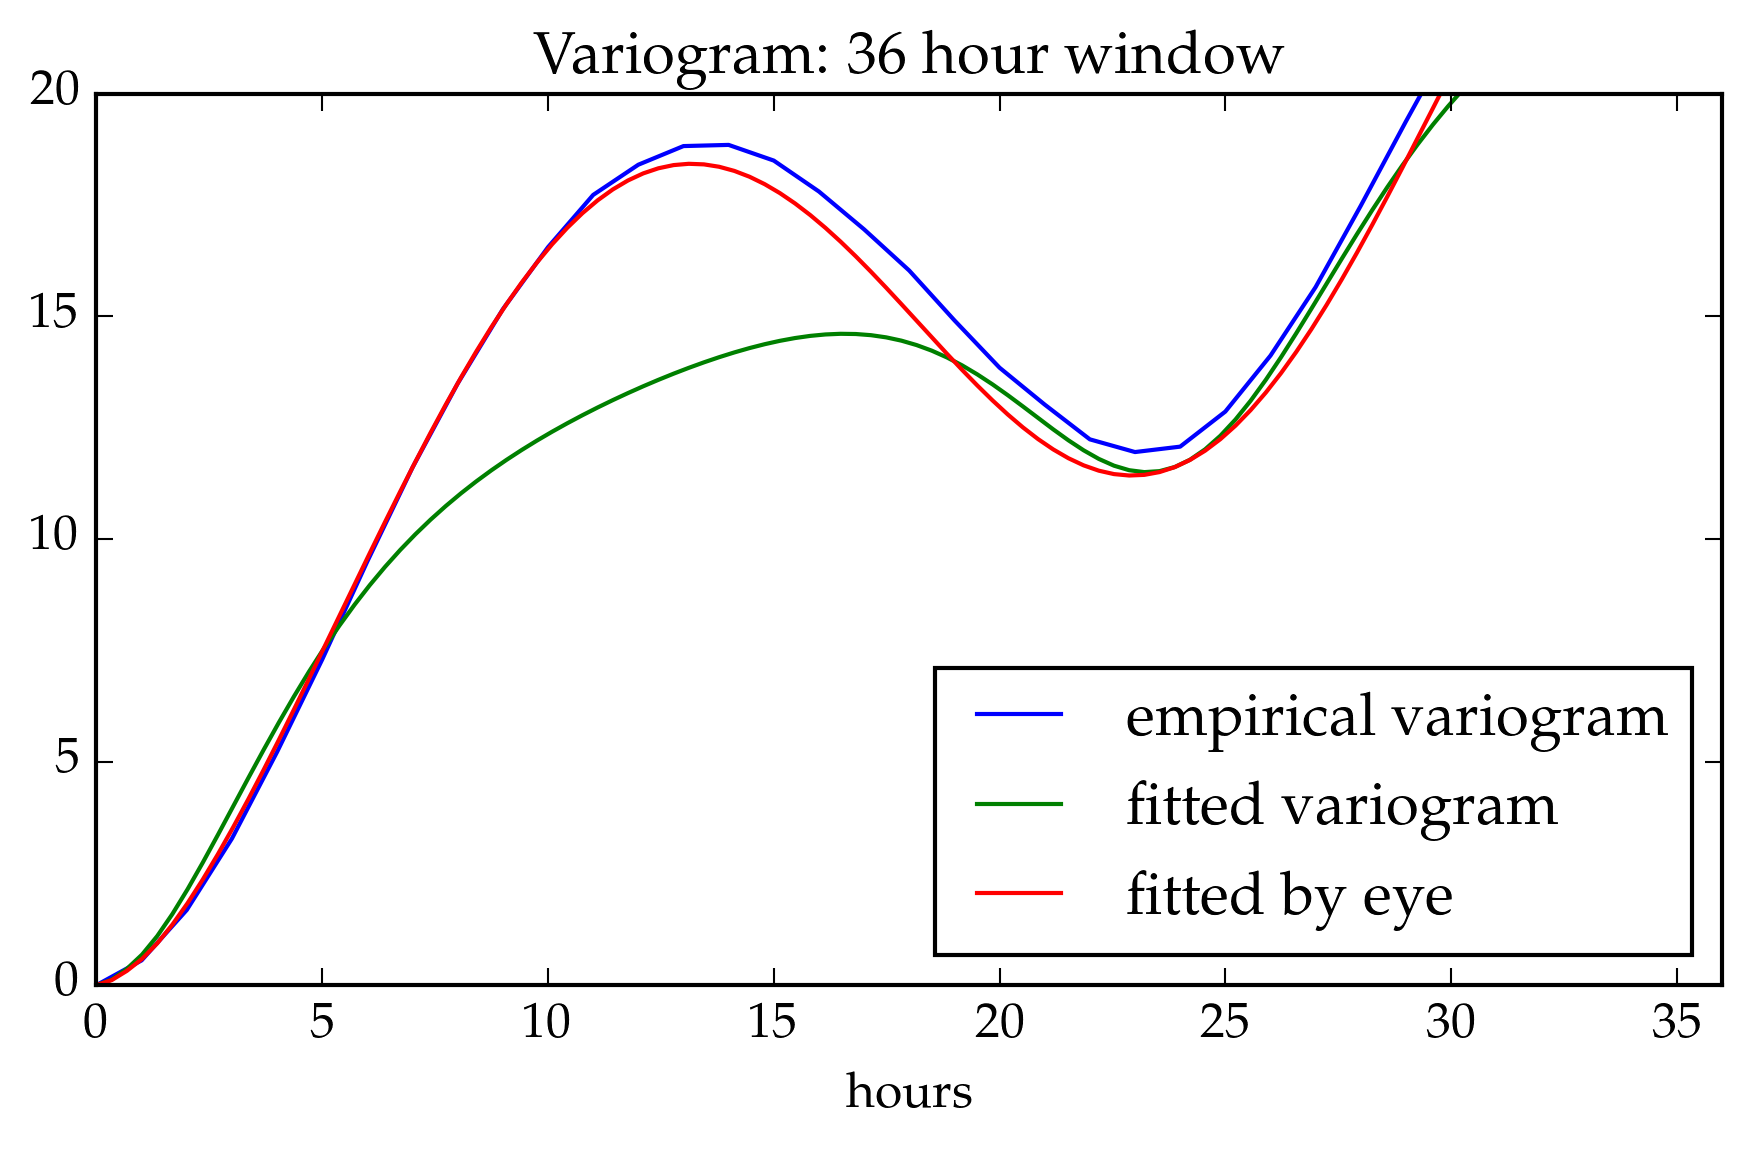

In [48]:
begin
    target_max = 12.0 # by eye
    rr = linspace(0.0, 24*14, 1000)
    𝓁 = 4.0
    bins_hours = convert(Vector{Float64}, _bins);
    bins_days = bins_hours/24;
    k = Periodic(log(𝓁), 0.0, log(k1.p))
    max_ck = 1.0-cov(k, evaluate(metric(k), [12.0], [0.0]))
    k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, log(k1.p))
    my_sumkernel = k_scaled + k2 + k3 + k4 + k5 + k6
    plt.plot(bins_hours, station_variog, label="empirical variogram")
    rr = linspace(0.0, 24*14, 1000)
    ck_r_mine = [cov(my_sumkernel, r) for r in rr]
    ck_r = [cov(_k_nonoise, r) for r in rr]
    plt.plot(rr, ck_r[1].-ck_r, label="fitted variogram")
    plt.plot(rr, ck_r_mine[1].-ck_r_mine, label="fitted by eye")
    plt.legend(loc="lower right")
    plt.xlabel("hours")
    plt.ylim(0,20)
    plt.xlim(0,36)
    plt.title("Variogram: 36 hour window")
end
;

In [46]:
begin
    target_max = 12.0 # by eye
    𝓁 = 4.0
    k = Periodic(log(𝓁), 0.0, log(k1.p))
    max_ck = 1.0-cov(k, evaluate(metric(k), [12.0], [0.0]))
    k_scaled = Periodic(log(𝓁), log(target_max/max_ck)/2.0, log(k1.p))
    my_sumkernel = k_scaled + k2 + k3 + k4 + k5 + k6
    gprealisations=GP[]
    istart=1
    while istart+chunksize < length(ts_arr)
        x = ts_arr[istart:istart+chunksize-1]
        y = temp_vec[istart:istart+chunksize-1]
        m = MeanConst(mean(y))
        gp = GP(x, y, m, my_sumkernel, _gpr.logNoise);
        push!(gprealisations, gp)
        istart+=chunksize
    end
    my_gpr = GPRealisations(gprealisations, _meanfunc, my_sumkernel, _gpr.logNoise, 1, 0.0, Float64[])
    update_mll!(my_gpr)
    @printf("mLL unmodified: %.1f\n", my_gpr.mLL)
    optimize!(my_gpr, noise=true, mean=false, kern=false, x_tol=1e-5, f_tol=1e-5)
    @printf("mLL after optimizing logNoise: %.1f\n", my_gpr.mLL)
    optimize!(my_gpr, mean=false, x_tol=1e-5, f_tol=1e-5)
    @printf("mLL after optimizing kernel: %.1f\n", my_gpr.mLL)
end
;

mLL unmodified: -12657.1
mLL after optimizing logNoise: -12656.8
mLL after optimizing kernel: -12570.7


In [47]:
# what we had before
Optim.minimum(opt_out)

12457.686411216819

OK so this is clearly not a good idea! I don't know why the log-likelihood degrades significantly with a kernel that fits the empirical variogram so much better! To summarize what we've seen:
* The periodic component of the kernel obtained by optimization of the marginal likelihood has a lower magnitude than what can be seen in the empirical variogram.
* At first I though maybe the periodic kernel isn't flexible enough to fit the corelation structure for measurements a small duration away from each other.
* But I was able to manually find parameters that fit the variogram much better.
* However, the kernel that fits the variogram better has a much worse marginal likelihood
* I don't know why this is the case.
* In spatial statistics, fitting the variogram is considered less good (statistically) than optimizing the marginal likelihood. Therefore, I prefer to trust the kernel obtained through likelihood optimization.